In [2]:
# Notebook behavior:

# Enable multiple outputs from one cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# autoreload extension: automaticall refresh imports when code is changed:
%load_ext autoreload
%autoreload 2

# run_ms_analysis.ipynb
---

# Tutorial notebook for processing MCCE microstate file in ms_out folder.

# Required mcce run output files:
### 1. head3.lst
### 2. file in ms_out/, a.k.a. the 'msout file'
 * Notes:
   - The ms_out folder is retained when the `--ms` flag is used at the command line for Step 4: `step4.py --ms`;
   - Format of the msout file name: pHXeHYms.tx at pH point X and Eh point Y;
   - The most typical filename encountered is "pH7eH0ms.txt", meaning the MCCE simulation was a pH titation run at pH7.
---

## Load the needed libraries and modules:

In [3]:
from collections import defaultdict
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import sys

%matplotlib inline

# Module needed to read the microstate file:
import ms_analysis_wc as msa

---
# Inputs
## Required user input: the path to the msout file:
 * e.g. 4lzt/ms_out/pH7eH0ms.txt
## Optional user input: list of residues of interest
---

# Get the paths to the input files using a folder name and a pH point (as string):

In [4]:
mcce_dir = Path("4lzt")  # local folder
ph_pt = "7"

h3_path, msout_file = msa.get_mcce_input_files(mcce_dir, ph_pt) 

msout_file
h3_path

# More specific name for output folder: KEEP?
outname = "crgms_wc"  # "output"
# Ensure the output directory exists:
output_dir = Path(outname)
if not output_dir.exists():
    output_dir.mkdir()
output_dir

PosixPath('4lzt/ms_out/pH7eH0ms.txt')

PosixPath('4lzt/head3.lst')

PosixPath('crgms_wc')

# Residues of interest

Note: Make sure to add the names of your residues of interest, such as quinone, here:

### Code for interactive input

#### Which kind of residues to consider (3-letter codes):

 * example string to give: ASP, pl9 GLU, LYS ARG HIS, TYR NTR PAA, HEM

    ```
    user_resoi = msa.split_spunct(input("Enter which kind of residues are of interest, e.g. ASP, HIS:\n"), upper=True)
    res_of_interest = msa.sort_resoi_list(user_resoi)
    res_of_interest
    ```

In [5]:
# Which kind of residues to consider (3-letter codes):

user_resoi = ["ASP", "HEM", "PL9", "GLU", "ARG", "HIS", "LYS", "TYR", "NTR", "CTR"]
print("Given resoi kinds:", user_resoi)

res_of_interest = msa.sort_resoi_list(user_resoi)
print("Sorted resoi kinds:", res_of_interest)

# Specific residues of interest.

# Here the list supplied must be conformer ids as they appear in the conformers list, without "-" or "+":
choose_resid = ["GLUA0035_", "HISA0015_", "ASPA0119_", "LYSA0013_"]
print("Chosen resid:", choose_resid)

Given resoi kinds: ['ASP', 'HEM', 'PL9', 'GLU', 'ARG', 'HIS', 'LYS', 'TYR', 'NTR', 'CTR']
Sorted resoi kinds: ['ASP', 'GLU', 'ARG', 'HIS', 'LYS', 'TYR', 'NTR', 'CTR', 'HEM', 'PL9']
Chosen resid: ['GLUA0035_', 'HISA0015_', 'ASPA0119_', 'LYSA0013_']


### Populate the conformers list:

In [6]:
conformers = msa.read_conformers(h3_path)
n_conformers = len(conformers)
print(f"Conformers count: {n_conformers:,}")

Conformers count: 314


# Instantiate `msa.MSout` class with the given msout file:

In [7]:
mc = msa.MSout(msout_file)
print(mc)

Number of microstates: 1,500,000
Number of unique microstates: 394,139
Energies: lowest_E: -184.97; average_E: -179.39; highest_E: -166.75


#### [ optional ]
#### Learn which methods come with the instantiated class (mc)
 * What's in the MSout class?

### In MCCE, residues are divided into fixed or free residue groups.
 * Only free residues appear in the microstate sate list.
 * Fixed residues can be ionizable residues so we need to include their contribution to the total charge, which is referred to here as __background charge__. 

#### Free residues information

In [8]:
# Uncomment to display:

#print("mc.free_residues list holds each free residues' conformers.\nSample data:\n", mc.free_residues[:2])

In [9]:
# Save the free_residues in a pandas.DataFrame, it will be one of the inputs to the function msa.ConcaCrgMsPandas:
free_residues_df = msa.free_residues_df(mc.free_residues, conformers, colname="Residue")
print(f"Number of free residues: {free_residues_df.shape[0]:,}")

Number of free residues: 47


In [10]:
# Uncomment to display:

#free_residues_df.head(3)
#free_residues_df.tail(3)

In [11]:
# Get their net charges into a df for combining with fixed_res

free_res_crg_df = msa.free_res2sumcrg_df(mc.microstates.values(), mc.free_residues, conformers)

In [12]:
# Uncomment to display:

#free_res_crg_df.head()

#### Fixed residues charge.
(Make sure to account for fixed residues charge for MD simulation protonation input.)

__For all fixed residues:__  
```
fixed_residues_info(
    fixed_iconfs: list, conformers: list, res_of_interest: list = IONIZABLES
) -> Tuple[float, pd.DataFrame, dict]:
```

In [13]:
# Note: pass an empty list, res_of_interest=[] to get all residues (default is ionizable residues)

background_crg, all_fixed_res_crg_df, all_fixed_res_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs, conformers)

print("Background charge:", background_crg)
print("Number of fixed residues:", len(all_fixed_res_crg_dict))

Background charge: 8.0
Number of fixed residues: 25


In [14]:
# Uncomment to display:

#all_fixed_res_crg_df.head()

### Combine free & fixed res with crg and save to csv:

In [15]:
all_res_crg_df = msa.combine_all_free_fixed_residues(free_res_crg_df, all_fixed_res_crg_df)
print(f"{all_res_crg_df.shape = }")

# Save to csv:
all_res_crg_df.to_csv(output_dir.joinpath("all_res_crg.csv"), index_label="Residue" )

all_res_crg_df.shape = (2, 72)


In [16]:
# Uncomment to display:

#all_res_crg_df

__For fixed residues among residues of interest:__  
#### Save the fixed residues in your residues of interest to a separate list, DataFrame & csv:

In [17]:
background_crg, fixed_resoi_crg_df, fixed_resoi_crg_dict = msa.fixed_residues_info(mc.fixed_iconfs,
                                                                                   conformers,
                                                                                   res_of_interest
                                                                                  )
print("Background charge:", background_crg)
n_fixed_resoi = len(fixed_resoi_crg_dict)
if n_fixed_resoi:
    print("Fixed res in residues of interest:", n_fixed_resoi)
    # save to csv:
    fixed_resoi_crg_df.to_csv(output_dir.joinpath("fixed_crg_resoi.csv"), index=False)
else:
    fixed_resoi_crg_df = None
    print("No fixed residues of interest.")

Background charge: 8.0
Fixed res in residues of interest: 25


In [18]:
# Uncomment to display:

#if n_fixed_resoi:
#    fixed_resoi_crg_df.head()

#### The following saves sorted microstates attributes (energy, count and microstate state) into a list;
The default sort in .sort_microstates() is by energy.

In [19]:
# mc.sort_microstates() returns a list of sorted ms objects:

ms_orig_lst = [[ms.E, ms.count, ms.state] for ms in mc.sort_microstates()]

### `ms_orig_lst` holds each microstate's attributes, i.e: [ms.E, ms.count, ms.state] sorted by energy.
#### The first attribute is the microstate energy; the second is the multiplicity of that state (mso.microstates holds unique ms info), the last one is the list of conformers in that state.

#### The conformer numbers align with head3.lst. Head3.lst starts at 1; ms lists start at 0.

In [20]:
# Sample data (uncomment to display):

#len(ms_orig_lst)
#print(ms_orig_lst[:2])

### Plot the enthalpy distribution using `msa.ms_energy_histogram`:
   ```
    msa.ms_energy_histogram(ms_by_enrg: list,
                            out_dir: pathlib.Path,
                            save_name: str = 'enthalpy_dist.pdf',
                            show: bool = False)
   ```

[INFO]: ms_energy_histogram:
	Histogram figure saved as crgms_wc/enthalpy_dist.pdf
[INFO]: ms_energy_histogram:
	Histogram figure saved as crgms_wc/enthalpy_dist.png


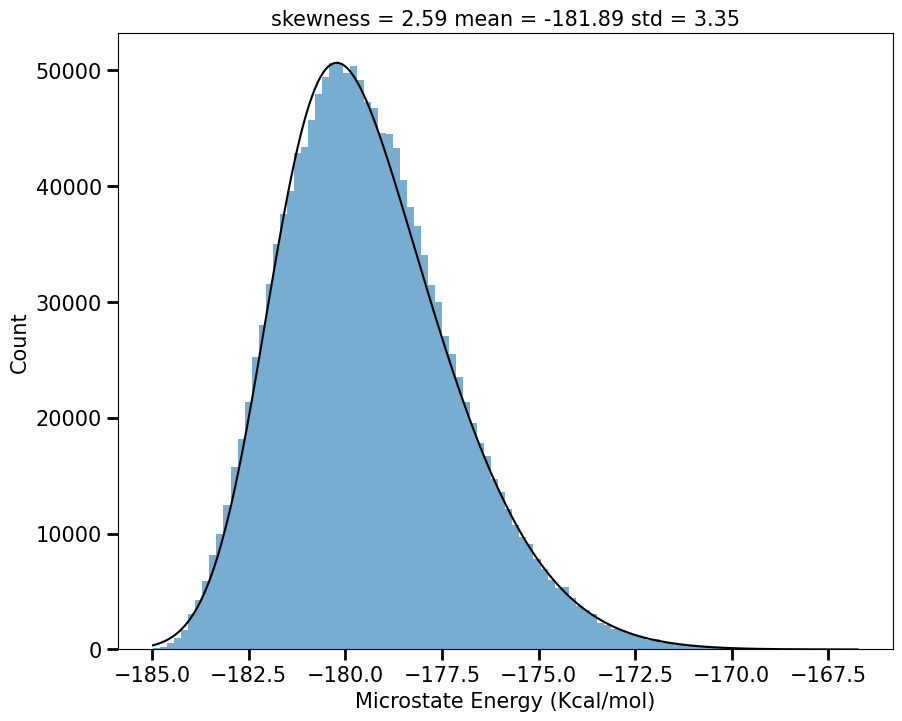

In [21]:
msa.ms_energy_histogram(ms_orig_lst, output_dir, show=True)

---
## Conformer microstates to charge microstates conversion

### This will map the microstate conformer id to its corresponding charge, and convert the conformer microstates from `mc` to charge microstates:

In [22]:
# Map conf index to conf charge:
id_vs_charge = msa.iconf2crg(conformers)

# This list structure is similar to that in ms_orig_lst;
# For each ms, it holds a list = [E, count, [crgms state]], but now the state list gives the charge
# of the free residues coformers:
crg_orig_lst = msa.ms2crgms(ms_orig_lst, id_vs_charge)

In [23]:
# Sample data (uncomment to display):

#print(crg_orig_lst[:2])

---
# Process the charge microstates into various outputs

# [ Cat ]
#### We could have of the processing bounds saved into a dict & wrap the following processing into one function, but the names of the figures are needed.

## Unfiltered charge microstates
### Note: Outputs of msa.find_uniq_crgms_count_order:
```
  0: all_crg_ms_unique,
  1: all_count,
  2: unique_crg_state_order,
  3: energy_diff_all (used in plot)
```

In [24]:
crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst)
print(f"Size of crgms_files[0], 'all_crg_ms_unique': {len(crgms_files[0]):,}")

# crgms_files:
#  0: all_crg_ms_unique,
#  1: all_count,
#  2: unique_crg_state_order,
#  3: energy_diff_all (used in plot)

all_crg_count_res = msa.concat_crgms_dfs(crgms_files[0],
                                         crgms_files[1],
                                         crgms_files[2], 
                                         free_residues_df,
                                         background_crg,
                                         res_of_interest=res_of_interest
                                         )

[INFO]: find_uniq_crgms_count_order:
	No energy bounds given: All microstates are selected.
[INFO]: find_uniq_crgms_count_order:
	Number of charge ms: 394,139
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 15


Size of crgms_files[0], 'all_crg_ms_unique': 15


In [25]:
# Sample data (uncomment to display):

#all_crg_count_res.head()

### This will plot the tautomer charge distribution of unqiue charge microstates based on the occupancy. 
Each dot are unique charge microstate and color coded based on the energy difference of that microstate appear in Monte Carlo run. Total charge is sum of background and free charge (protein charge).

# [ Cat ]
### In `msa.unique_crgms_histogram`, the color variation (hue) indicates the size of the energy range for non-unique crgms.

[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_all_E_ph7.pdf
[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_all_E_ph7.png


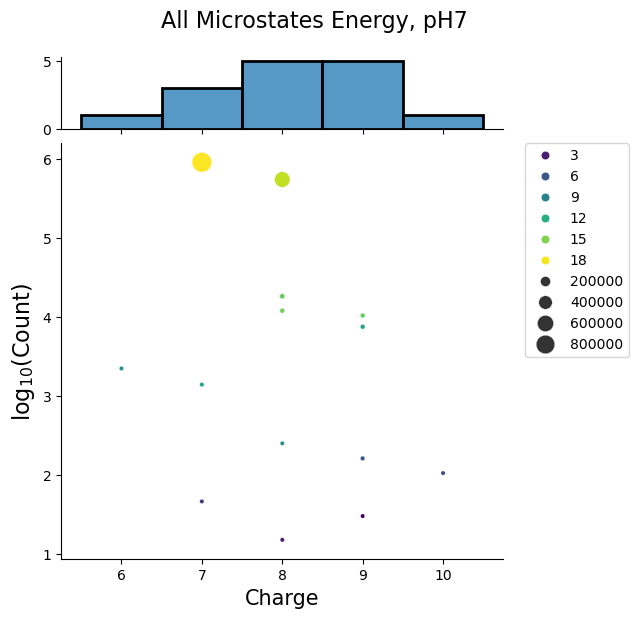

In [26]:
title = "All Microstates Energy, pH" + ph_pt
msa.unique_crgms_histogram(crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_all_E_ph"+ph_pt+".pdf",
                           show=True)

# [ Raihan ]
#### A very important thing here in this dot plot we need to be clear what is these dots numbers mean?
#### In fact we have a different type of output figure for this. I will share with you. I believe these values are eneergy range of the microstates, but the numbers sometimes do not make sense.
---

#### This is to get the unique charge microstates >= lowest energy + 1.36 kcal/mol. 
Make sure your supply list is sorted based on energy in ascending order. 
The order in the dataframe is within the selected energy range.

In [27]:
begin_E = crg_orig_lst[0][0]
end_E = crg_orig_lst[0][0] + 1.36
print(f"Using energy bounds ({begin_E}, {end_E})")

lowest_crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst,
                                                   begin_energy = begin_E,
                                                   end_energy = end_E
                                                   )
low_crg_count_res = msa.concat_crgms_dfs(lowest_crgms_files[0],
                                         lowest_crgms_files[1],
                                         lowest_crgms_files[2], 
                                         free_residues_df,
                                         background_crg,
                                         res_of_interest)

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 2,198
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 2


Using energy bounds (-184.972214, -183.612214)


In [28]:
# Sample data (uncomment to display):

#low_crg_count_res.head(3) 

[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_lowest_E_ph7.pdf
[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_lowest_E_ph7.png


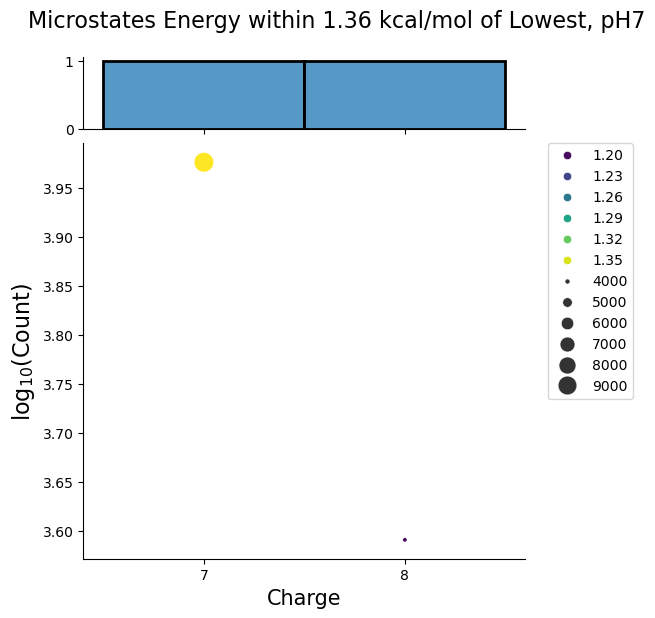

In [29]:
title = "Microstates Energy within 1.36 kcal/mol of Lowest, pH"+ph_pt
msa.unique_crgms_histogram(lowest_crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_lowest_E_ph"+ph_pt+".pdf",
                           show=True)

#### This is to get the unique charge microstates within +/- 0.5 pH unit (+/- 0.68 kcal/mol) of average microstate energy

In [30]:
begin_mc_aver = mc.average_E - 0.68
end_mc_aver = mc.average_E + 0.68
print(f"Using the average microstate energy +/- 0.5 pH unit (+/- 0.68 kcal/mol): ({begin_mc_aver}, {end_mc_aver})")

average_crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst,
                                                    begin_energy = begin_mc_aver,
                                                    end_energy = end_mc_aver
                                                    )
av_crg_count_res = msa.concat_crgms_dfs(average_crgms_files[0],
                                        average_crgms_files[1],
                                        average_crgms_files[2], 
                                        free_residues_df,
                                        background_crg,
                                        res_of_interest
                                       )

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 93,790


Using the average microstate energy +/- 0.5 pH unit (+/- 0.68 kcal/mol): (-180.07293514108827, -178.71293514108825)


[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 9


In [31]:
# Sample data (uncomment to display):

#av_crg_count_res.head(3) 

[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_aver_E_ph7.pdf
[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_aver_E_ph7.png


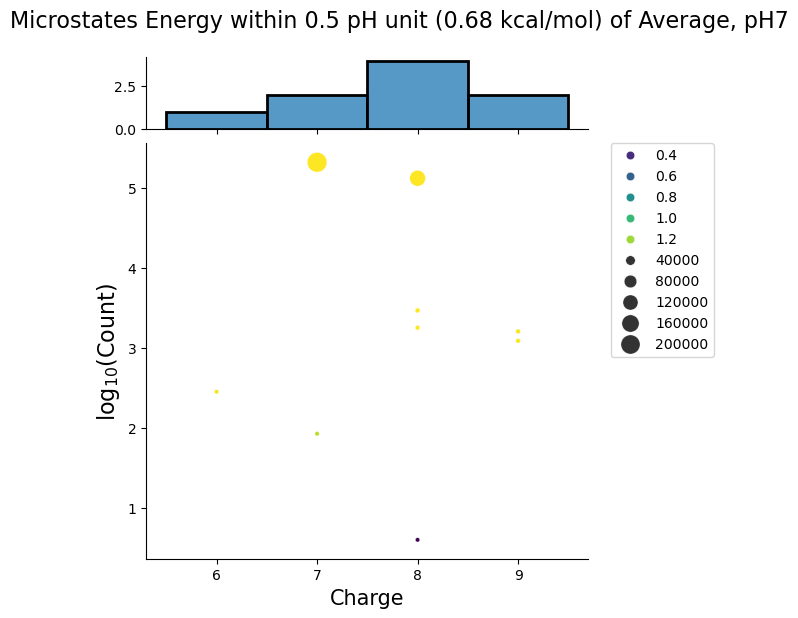

In [32]:
title = "Microstates Energy within 0.5 pH unit (0.68 kcal/mol) of Average, pH"+ph_pt
msa.unique_crgms_histogram(average_crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_aver_E_ph"+ph_pt+".pdf",
                           show=True)

#### This is to get the unique charge microstates >= 1 KT unit (1.36 kcal/mol) of highest microstate energy

In [33]:
highest_crgms_files = msa.find_uniq_crgms_count_order(crg_orig_lst,
                                                    begin_energy = (mc.highest_E - 1.36),
                                                    end_energy = mc.highest_E
                                                    )
high_crg_count_res = msa.concat_crgms_dfs(highest_crgms_files[0],
                                          highest_crgms_files[1],
                                          highest_crgms_files[2], 
                                          free_residues_df,
                                          background_crg,
                                          res_of_interest)

[INFO]: find_uniq_crgms_count_order:
	Number of energy-filtered charge ms: 9
[INFO]: find_uniq_crgms_count_order:
	Number of unique charge ms: 3


In [34]:
# Sample data (uncomment to display):

#high_crg_count_res.head(3) 

[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_highest_E_ph7.pdf
[INFO]: unique_crgms_histogram:
	Figure saved: crgms_wc/crgms_logcount_vs_highest_E_ph7.png


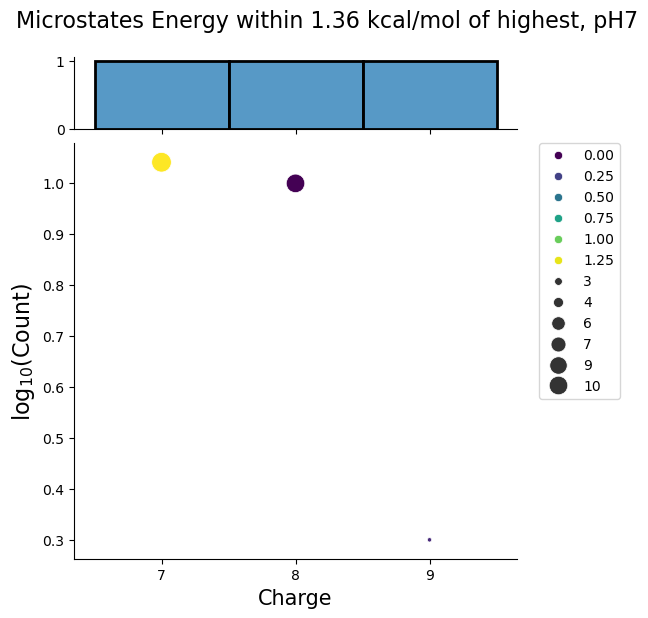

In [35]:
title = "Microstates Energy within 1.36 kcal/mol of highest, pH"+ph_pt
msa.unique_crgms_histogram(highest_crgms_files,
                           background_crg,
                           title,
                           output_dir,
                           save_name="crgms_logcount_vs_highest_E_ph"+ph_pt+".pdf",
                           show=True)

## Save all these 3 DataFrames and non titrable residues charge information:
 * low_crg_count_res
 * av_crg_count_res
 * high_crg_count_res
 * fixed_resoi_crg_df

In [36]:
# Writing to Excel will fail if xlswriter is not installed:
# see https://anaconda.org/conda-forge/xlsxwriter
try:
    # this will be a user specified name:
    xl_filename = "charge_ms_pH"+ ph_pt + ".xlsx"
    outfile_xl = output_dir.joinpath(xl_filename)

    # Create an ExcelWriter object
    with pd.ExcelWriter(outfile_xl,
                        engine="xlsxwriter"
                       ) as writer:
        # Write your dataframes to different sheets
        low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
        av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
        high_crg_count_res.to_excel(writer, sheet_name='high_crg_count_res')
        fixed_resoi_crg_df.to_excel(writer, sheet_name='fixed_residues_crg')

        # Save the Excel file
        writer.save()
        print(f"Saved Excel file {outfile_xl!s}.")

except Exception as e:
    if type(e).__name__ == "ModuleNotFoundError":
        print("The excel writer engine must be installed;", e)
    else:
        print(f"Error occurred while saving Excel file: {str(e)}")

The excel writer engine must be installed; No module named 'xlsxwriter'


In [37]:
# Save all_crg_count_res to a CSV file after adding fixed resoi data:

out = msa.add_fixed_res_crg(all_crg_count_res, fixed_resoi_crg_df)

crg_count_csv = output_dir.joinpath(f"all_crg_count_res_ph{ph_pt}.csv")
try:
    out.to_csv(crg_count_csv, header=True)
    print(f"DataFrame all_crg_count_res saved to {crg_count_csv!s}.")

except Exception as e:
    print(f"Error occurred while saving all_crg_count_res to csv file: {str(e)}")

DataFrame all_crg_count_res saved to crgms_wc/all_crg_count_res_ph7.csv.


---
# Post-processing of already saved main crgms file to get the correlation matrix for residues. 

In [38]:
# This is for correlation.

all_crg_df = pd.read_csv(crg_count_csv, index_col=0)

In [39]:
df_choose_res_data = msa.choose_res_data(all_crg_df, choose_resid)
df_choose_res_data["Occupancy"] = round(df_choose_res_data["Count"]/sum(df_choose_res_data["Count"]), 2)

file_name = "crg_count_res_of_interest.csv"
df_choose_res_data.to_csv(output_dir.joinpath(file_name), header=True)

In [40]:
df_chosen_res_renamed = msa.rename_order_residues(df_choose_res_data)

In [41]:
# Uncomment to display:

#df_chosen_res_renamed

---
# Weighted correlation
### Define a cutoff if one different from 0 (default) is needed.

In [42]:
cutoff = 0.05

if df_chosen_res_renamed.shape[0] > 1:
     df_correlation = msa.WeightedCorr(df=df_chosen_res_renamed,
                                       wcol="Count",
                                       cutoff=cutoff)(method="pearson")
else:
    print("Too few rows for correlation.")

In [43]:
# Uncomment to display:

#df_correlation

## Create a heatmap to display the residue correlation:

[INFO]: corr_heatmap:
	Correlation heat map saved as crgms_wc/corr.pdf
[INFO]: corr_heatmap:
	Correlation heat map saved as: crgms_wc/corr.png


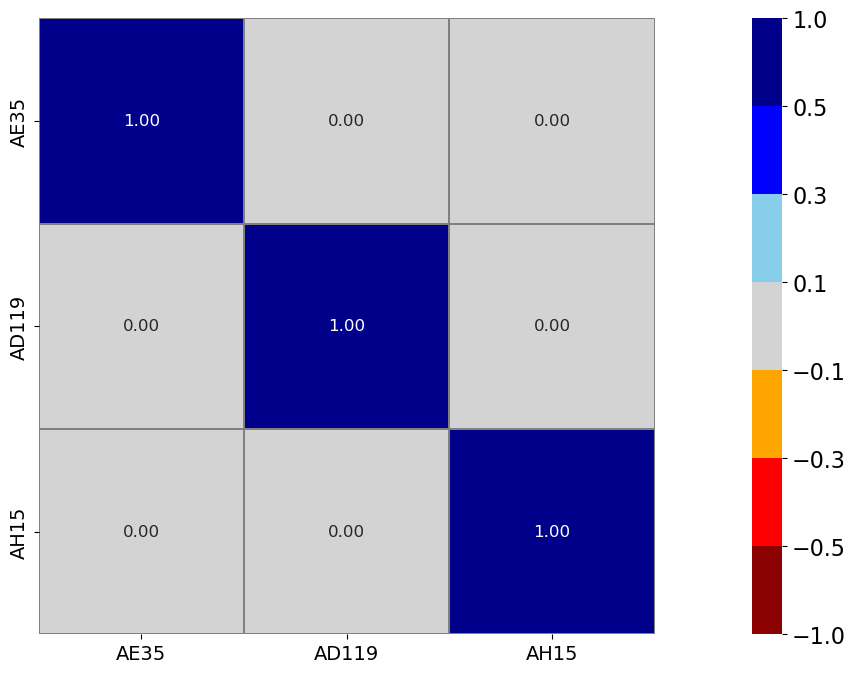

In [44]:
msa.corr_heatmap(df_correlation,
                 out_dir=output_dir,
                 #save_name="corr.pdf",  default name
                 show=True)

---
## Extra function to test sorted heatmap with larger df

In [45]:
# Test sorted matrix with larger df:

def test_sorted_matrix():
    # Sample DataFrame
    cols = ["AE35","AD119", "AH15", "AHEM1", "APAA1", "APAA2", "AMQ8"]
    n = 15
    data = {x: np.random.rand(n) for x in cols}
    df = pd.DataFrame(data)
    
    # Compute correlation matrix
    corr_matrix = df.corr()
    
    print("Before sort:")
    corr_matrix
    
    # Sort the correlation matrix by the sum of correlation;
    # this is what msa.corr_heatmap uses:
    corr_sums = corr_matrix.sum()
    sorted_corr_matrix = corr_matrix.loc[corr_sums.sort_values(ascending=False).index,
                                         corr_sums.sort_values(ascending=False).index]
    corr_matrix.abs().sum()
    print("Sorted:")
    sorted_corr_matrix

    # save here
    msa.corr_heatmap(sorted_corr_matrix,
                      save_name="corr.pdf",
                      show=True)
    return

[INFO]: corr_heatmap:
	Correlation heat map saved as corr.pdf


Before sort:
Sorted:


[INFO]: corr_heatmap:
	Correlation heat map saved as: corr.png


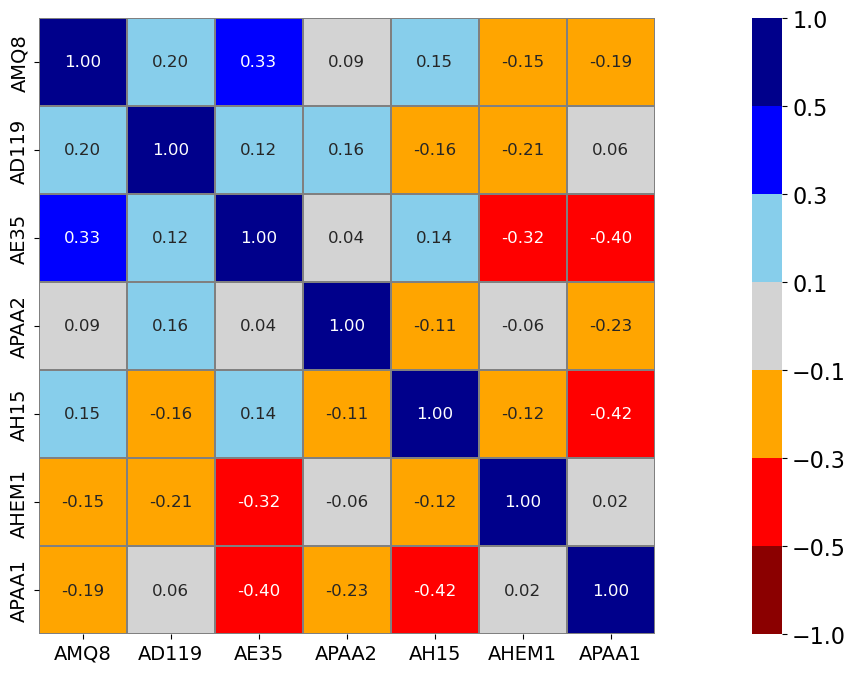

In [46]:
test_sorted_matrix()